In [51]:
import pandas as pd
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
df = pd.read_csv("/Users/ayumuueda/Desktop/UC-Transfer-Analyzer/data/berkeley_table.csv")

In [53]:
df.columns

Index(['Major name', 'Admit GPA range', 'Admit rate', 'Enroll GPA range',
       'Yield rate', 'Admits', 'Applicants', 'Enrolls', 'year'],
      dtype='object')

In [54]:
df.columns = ["Major_name", "Admit_GPA_range","Admit_rate","Enroll_GPA_range","Yield_rate","Admits","Applicants","Enrolls", 'year']

In [55]:
df

,Major_name,Admit_GPA_range,Admit_rate,Enroll_GPA_range,Yield_rate,Admits,Applicants,Enrolls,year
0,Environmental economics & policy (l&S),3.69 - 4.00,0.282353,3.64 - 3.98,0.750000,24,85,18,2012
1,Conservation & resource studies (conr),3.51 - 3.81,0.500000,3.48 - 3.78,0.909091,22,44,20,2012
2,Environmental economics & policy (conr),3.77 - 3.90,0.333333,3.81 - 3.90,0.750000,20,60,15,2012
3,Environmental science (conr),3.64 - 3.92,0.166667,3.60 - 3.90,0.642857,14,84,9,2012
4,Society and environment (conr),3.49 - 3.75,0.384615,3.50 - 3.79,0.880000,25,65,22,2012
...,...,...,...,...,...,...,...,...,...
695,Anthropology (l&S),3.62 - 3.95,0.437288,3.47 - 3.95,0.457364,129,295,59,2022
696,Economics (l&S),3.77 - 4.00,0.137084,3.77 - 4.00,0.815029,173,1262,141,2022
697,Political economy (l&S),3.61 - 4.00,0.423913,3.52 - 3.92,0.692308,39,92,27,2022
698,Political science (l&S),3.70 - 4.00,0.210332,3.53 - 3.94,0.504386,228,1084,115,2022


In [56]:
def first_q(col):
    return float(col[0:4])

def third_q(col):
    return float(col[7:])

In [57]:
def preprocess(df):
    
    dump_list = []

    for i, k in dict(df["Major_name"].value_counts()).items():
        if k == 1 :
            dump_list.append(i)

    df = df[~df["Major_name"].isin(dump_list)]
    df = df[df["Admit_GPA_range"] != "masked"]
    df = df[df["Enroll_GPA_range"] != "masked"]
    df = df.sort_values(by=["Major_name", "year"])
    df["lag"] = df.groupby(["Major_name"])["Admit_rate"].shift(-1).fillna(0)
    df["25th admit"] = df["Admit_GPA_range"].apply(first_q)
    df["25th enroll"] = df["Enroll_GPA_range"].apply(first_q)
    df["75th admit"] = df["Admit_GPA_range"].apply(third_q)
    df["75th enroll"] = df["Enroll_GPA_range"].apply(third_q)
    df["approx median admit"] = (df["25th admit"] + df["75th admit"]) / 2
    df["approx median Enroll"] = (df["25th enroll"] + df["75th enroll"]) / 2

    df = df.drop(["25th admit","25th enroll", "75th admit", "75th enroll", "approx median admit", "Enrolls"], axis=1)
    df = df.drop(["Admit_GPA_range","Enroll_GPA_range"], axis = 1)
    return df


In [58]:
test_x.columns

Index(['Admit rate', 'Yield rate', 'Admits', 'Applicants',
       'approx median Enroll'],
      dtype='object')

In [59]:
df = preprocess(df)

In [60]:
df["max_year"] = df.groupby("Major_name")['year'].transform(max)

In [61]:
df

,Major_name,Admit_rate,Yield_rate,Admits,Applicants,year,lag,approx median Enroll,max_year
236,African-american studies (l&S),0.161290,1.000000,5,31,2016,0.230769,3.575,2022
426,African-american studies (l&S),0.230769,0.555556,9,39,2019,0.303030,3.690,2022
636,African-american studies (l&S),0.303030,0.700000,10,33,2022,0.000000,3.360,2022
6,American studies (l&S),0.452381,0.789474,19,42,2012,0.416667,3.370,2022
63,American studies (l&S),0.416667,0.700000,10,24,2013,0.473684,3.375,2022
...,...,...,...,...,...,...,...,...,...
284,Urban studies (coed),0.125000,1.000000,5,40,2016,0.282051,3.355,2022
348,Urban studies (coed),0.282051,0.727273,11,39,2017,0.205882,3.460,2022
412,Urban studies (coed),0.205882,0.714286,7,34,2018,0.225806,3.380,2022
620,Urban studies (coed),0.225806,0.857143,7,31,2021,0.261905,3.735,2022


In [62]:
test = df[df['max_year'] == df['year']]
train = df[df['max_year'] != df['year']]
actual = test['Admit_rate']
train_y = train['lag']
test_x = test.drop(["Major_name", "max_year","year", "lag"], axis=1)
train_x = train.drop(["Major_name", "max_year", "year", "lag"], axis=1)

metric is RMSE, MAE, MSE 

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(train_x, train_y)
predicted_random = regr.predict(test_x)

In [64]:
clf = Ridge(alpha=1.0)
clf.fit(train_x, train_y)
predicted_ridge = clf.predict(test_x)

In [65]:
# loading library
import pickle
# create an iterator object with write permission - model.pkl
with open('models/ridge_berk_pkl', 'wb') as files:
    pickle.dump(clf, files)

In [66]:
test['predicted_ridge'] = predicted_ridge
test['predicted_random'] = predicted_random
test['this_year'] = actual

/var/folders/h0/sl38029x0_j4khlt53w1_8y00000gn/T/ipykernel_82197/2758274165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_ridge'] = predicted_ridge
/var/folders/h0/sl38029x0_j4khlt53w1_8y00000gn/T/ipykernel_82197/2758274165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_random'] = predicted_random
/var/folders/h0/sl38029x0_j4khlt53w1_8y00000gn/T/ipykernel_82197/2758274165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [78]:
test_x.iloc[[0]].astype(float)

,Admit_rate,Yield_rate,Admits,Applicants,approx median Enroll
636,0.30303,0.7,10.0,33.0,3.36


In [80]:
clf.predict(test_x.iloc[[0]])[0]

0.3442709510200563

/var/folders/h0/sl38029x0_j4khlt53w1_8y00000gn/T/ipykernel_82197/1534458401.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True)


<Axes: >

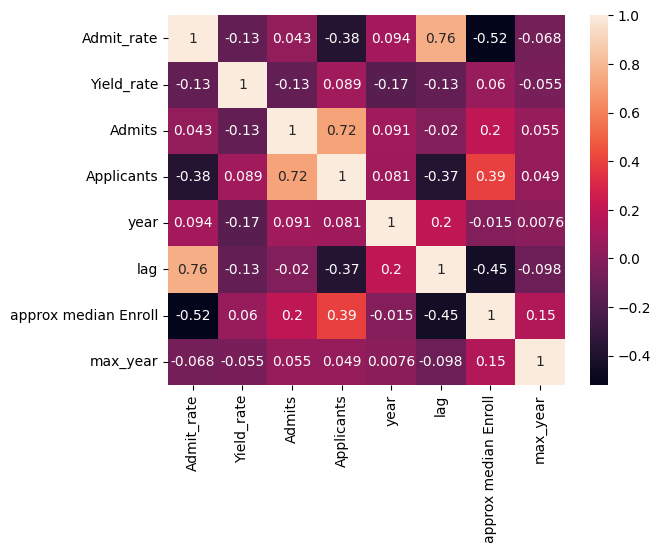

In [68]:
sns.heatmap(train.corr(), annot=True)